In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_combined = pd.read_csv('/kaggle/input/preprocessed-post-csv/preprocessed_post.csv')
# print(df_combined.head(5))

df_combined.dropna(subset=['processed_post'], inplace=True)
print('df-shape',df_combined.shape)



#undersampling

count_class_0, count_class_1 = df_combined.label.value_counts()

# Divide by class
df_class_0 = df_combined[df_combined['label'] == 0]
df_class_1 = df_combined[df_combined['label'] == 1]

print(count_class_1," df class 1")
import math
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())


import gensim

sentences = [post.split() for post in df_test_under['processed_post']]
print('1234',sentences[:2])
word2vec_model = gensim.models.Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)
print('12345')
vocab_size = len(word2vec_model.wv)
print('123456',vocab_size)

def embed_sentence(sentence, word2vec_model):
    return np.array([word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(300) for word in sentence])

import numpy as np
embeded_post= [embed_sentence(post.split(), word2vec_model) for post in df_test_under['processed_post']]
print('1234567')

from keras.preprocessing.sequence import pad_sequences
#X_padded = pad_sequences([x for x in embeded_post], maxlen=300, dtype='float32', padding='post')

maxlen = 100

# Pad sequences with maxlen
X_padded = pad_sequences([x for x in embeded_post], maxlen=maxlen, dtype='float32', padding='post')

print('12345678')
print(f'X_padded shape: {X_padded.shape}')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/last_stable_model/keras/default/1/gru_model.h5
/kaggle/input/preprocessed-post-csv/preprocessed_post.csv
df-shape (101357, 4)
13105  df class 1
Random under-sampling:
label
0    13105
1    13105
Name: count, dtype: int64
1234 [["y'all", 'get'], ['love', 'awesone', 'cat']]
12345
123456 41924
1234567
12345678
X_padded shape: (26210, 100, 300)


In [2]:
#print(embeded_post[:5])

In [3]:
print(df_combined.head(5))

                                                Post Suicidal  label  \
0   I have a massive list of e-mails I've collect...       No      0   
1   What's the best piece of trivia that you know...       No      0   
2  Basketball coach forced to resign because she ...       No      0   
3  Is this the most optimal way to draw the First...       No      0   
4  Can we get some sort of directory style organi...       No      0   

                                      processed_post  
0    massive list e mail collect gig play big cou...  
1                       good piece trivium know true  
2  basketball coach force resign show team movie ...  
3  optimal way draw line tv turn infrared laser d...  
4  sort directory style organize category stuff s...  


In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_padded, df_test_under['label'], test_size=0.2, random_state=42, stratify=df_test_under['label'])

In [120]:
from sklearn.utils import class_weight

# Assuming y_train contains your labels (0 for non-suicidal, 1 for suicidal)
class_weights = class_weight.compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create a dictionary for class weights
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(class_weight_dict)

{0: 1.0, 1: 1.0}


In [6]:
print(X_train.shape)

(36694, 100, 300)


In [7]:
print(X_train.shape[0] == y_train.shape[0]) 

True


In [8]:
df_combined['label'].value_counts()

label
0    88252
1    13105
Name: count, dtype: int64

In [131]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
X_train.shape

(36694, 100, 300)

In [127]:
print(X_train.shape, X_test.shape,'test train split')

(20968, 100, 300) (5242, 100, 300) test train split


In [128]:
np.bincount(y_train)

array([10484, 10484])

In [129]:
np.bincount(y_test)

array([2621, 2621])

In [14]:
# from keras.models import Sequential
# from keras.layers import GRU, Dense, Dropout, Input

# # Assuming you have defined y_train (your target labels)
# model = Sequential([
#         Input(shape=(X_train.shape[1], X_train.shape[2])),
#     GRU(128),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight_dict)

Epoch 1/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 106s 155ms/step - accuracy: 0.7463 - loss: 0.4766 - val_accuracy: 0.9010 - val_loss: 0.2459
Epoch 2/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 100s 153ms/step - accuracy: 0.8951 - loss: 0.2613 - val_accuracy: 0.9029 - val_loss: 0.2238
Epoch 3/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 142s 152ms/step - accuracy: 0.9067 - loss: 0.2351 - val_accuracy: 0.9138 - val_loss: 0.2163
Epoch 4/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 101s 154ms/step - accuracy: 0.9130 - loss: 0.2225 - val_accuracy: 0.9113 - val_loss: 0.2127
Epoch 5/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 142s 153ms/step - accuracy: 0.9184 - loss: 0.2129 - val_accuracy: 0.9126 - val_loss: 0.2143
Epoch 6/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 102s 155ms/step - accuracy: 0.9218 - loss: 0.2009 - val_accuracy: 0.9185 - val_loss: 0.2064
Epoch 7/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 99s 152ms/step - accuracy: 0.9291 - loss: 0.1864 - val_accuracy: 0.9155 - val_loss: 0.2083
Epoch 8/15
656/656 ━━━━━━━━━━━━━━━━━━━━ 100s 152ms/step - accuracy: 0.9281 - 

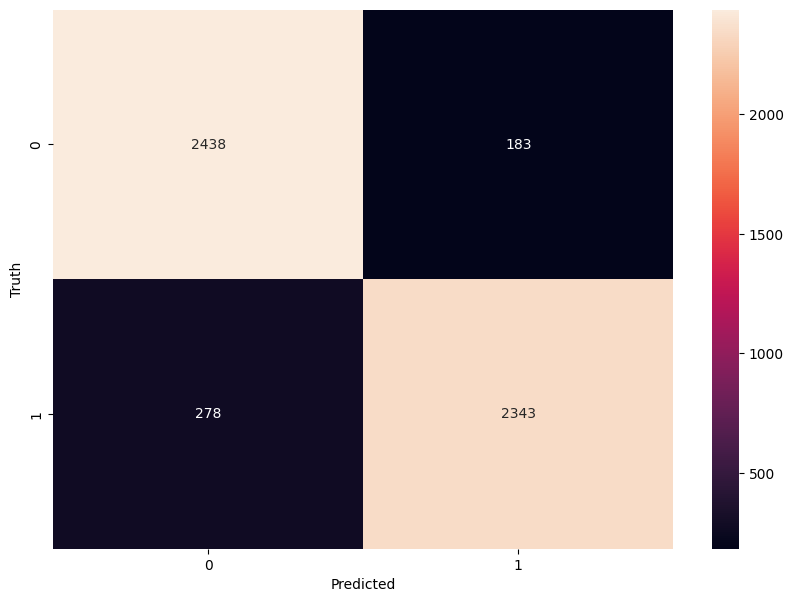

In [136]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input

# Assuming you have defined y_train (your target labels)
us_model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    GRU(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

us_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
us_model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

y_pred = us_model.predict(X_test)
print("preds", y_pred[:5], "\n")

y_predicted_labels = [1 if y>.5 else 0 for y in y_pred]

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)


cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cl_rep = classification_report(y_test,y_predicted_labels)
print(cl_rep)


In [67]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input

# Assuming you have defined y_train (your target labels)
x2_model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

x2_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
x2_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight_dict)

Epoch 1/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 162s 160ms/step - accuracy: 0.7768 - loss: 0.5477 - val_accuracy: 0.8825 - val_loss: 0.2950
Epoch 2/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 153s 156ms/step - accuracy: 0.9053 - loss: 0.2505 - val_accuracy: 0.9163 - val_loss: 0.2170
Epoch 3/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 203s 158ms/step - accuracy: 0.9167 - loss: 0.2218 - val_accuracy: 0.9201 - val_loss: 0.2071
Epoch 4/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 157s 160ms/step - accuracy: 0.9200 - loss: 0.2069 - val_accuracy: 0.8999 - val_loss: 0.2398
Epoch 5/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 156s 159ms/step - accuracy: 0.9246 - loss: 0.1957 - val_accuracy: 0.9150 - val_loss: 0.2125
Epoch 6/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 160s 162ms/step - accuracy: 0.9281 - loss: 0.1811 - val_accuracy: 0.9149 - val_loss: 0.2139
Epoch 7/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 201s 161ms/step - accuracy: 0.9320 - loss: 0.1726 - val_accuracy: 0.9101 - val_loss: 0.2233
Epoch 8/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 161s 163ms/step - accuracy: 0.9364 -

In [101]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout, Input

# Assuming you have defined y_train (your target labels)
model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64,return_sequences=True),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),class_weight=class_weight_dict)

Epoch 1/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 198s 195ms/step - accuracy: 0.7436 - loss: 0.5505 - val_accuracy: 0.9070 - val_loss: 0.2400
Epoch 2/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 192s 196ms/step - accuracy: 0.9074 - loss: 0.2464 - val_accuracy: 0.9125 - val_loss: 0.2219
Epoch 3/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 190s 193ms/step - accuracy: 0.9162 - loss: 0.2211 - val_accuracy: 0.9167 - val_loss: 0.2091
Epoch 4/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.9230 - loss: 0.2022 - val_accuracy: 0.9168 - val_loss: 0.2128
Epoch 5/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 189s 192ms/step - accuracy: 0.9256 - loss: 0.1933 - val_accuracy: 0.9189 - val_loss: 0.2108
Epoch 6/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 190s 194ms/step - accuracy: 0.9287 - loss: 0.1867 - val_accuracy: 0.9192 - val_loss: 0.2100
Epoch 7/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 190s 193ms/step - accuracy: 0.9331 - loss: 0.1765 - val_accuracy: 0.8869 - val_loss: 0.2706
Epoch 8/10
983/983 ━━━━━━━━━━━━━━━━━━━━ 191s 194ms/step - accuracy: 0.9330 -

In [143]:
model.save('most_stable-one-less-layers.h5')

246/246 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step
preds [[0.992316  ]
 [0.0646642 ]
 [0.9895606 ]
 [0.0300881 ]
 [0.02364654]] 

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      5242
           1       0.84      0.93      0.88      2621

    accuracy                           0.92      7863
   macro avg       0.90      0.92      0.91      7863
weighted avg       0.92      0.92      0.92      7863



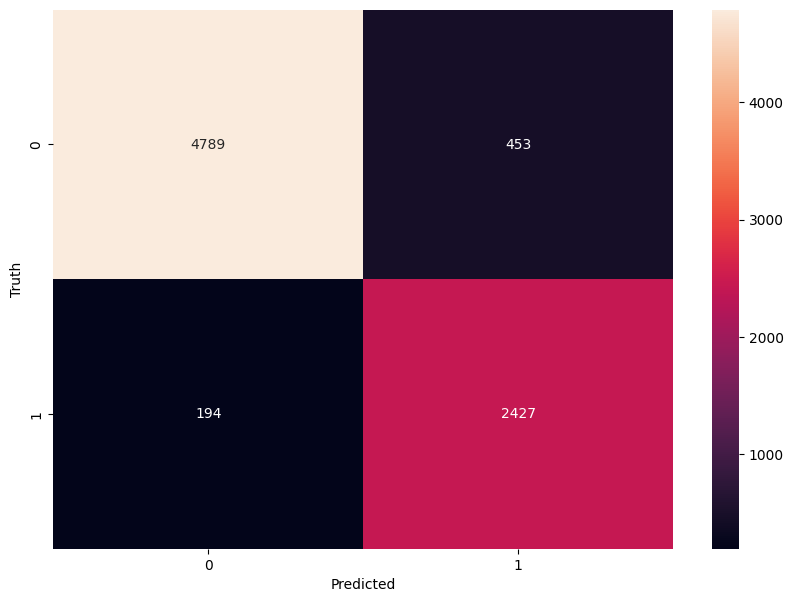

In [103]:

from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

y_pred = model.predict(X_test)
print("preds", y_pred[:5], "\n")

y_predicted_labels = [1 if y>.5 else 0 for y in y_pred]

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)


cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cl_rep = classification_report(y_test,y_predicted_labels)
print(cl_rep)

246/246 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step
preds [[0.98467046]
 [0.01997948]
 [0.9957943 ]
 [0.00180291]
 [0.00383752]] 

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      5242
           1       0.84      0.92      0.88      2621

    accuracy                           0.92      7863
   macro avg       0.90      0.92      0.91      7863
weighted avg       0.92      0.92      0.92      7863



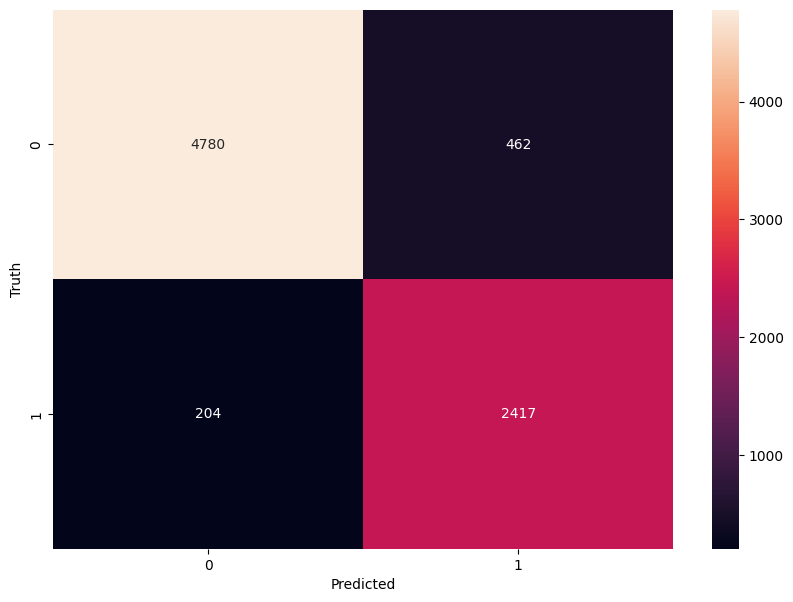

In [71]:

from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

y_pred = x2_model.predict(X_test)
print("preds", y_pred[:5], "\n")

y_predicted_labels = [1 if y>.5 else 0 for y in y_pred]

cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)


cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

cl_rep = classification_report(y_test,y_predicted_labels)
print(cl_rep)

In [ ]:
print(X)

In [ ]:
df_combined['label'].value_counts()

In [ ]:
import matplotlib.pyplot as plt

# Calculate the length of each post
sequence_lengths = [len(post.split()) for post in df_combined['processed_post']]

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Number of Posts')
plt.title('Distribution of Post Lengths')
plt.show()

In [140]:
def preprocess_data(post):

  doc = nlp(post)
  filtered_tokens = []
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)

  return ' '.join(filtered_tokens).lower()

In [102]:
import spacy

new_posts = ["I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything.😅\n\nEveryday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.\n\nI feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about.\n\nI wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')'",
           "I am going to USA",
            "I will commit suicide.",
            "I hate my life",
            "I have headache",
            "I have passed my exam",
            "I am reading a book"]

processes_new_posts = [preprocess_data(p) for p in new_posts]

sentences_test = [post.split() for post in processes_new_posts]
print('sentences',sentences_test[:2])


vocab_size = len(word2vec_model_test.wv)
print('123456',vocab_size)

def embed_sentence(sentence, word2vec_model):
    return np.array([word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(300) for word in sentence])

import numpy as np
embeded_post_test= [embed_sentence(post.split(), word2vec_model) for post in new_posts]
X_padded_test = pad_sequences([x for x in embeded_post_test], maxlen=maxlen, dtype='float32', padding='post')

prediction = model.predict(X_padded_test)
prediction

 I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything.😅

Everyday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.

I feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about.

I wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')' is processed

 I am going to USA is processed

 I will commit suicide. is processed

 I hate my life is processed

 I have headache is processed

 I have passed my exam is processed

 I am reading a book is processed

sentences [['remeber', 'time', 'genuinly', 'happy', 'month', 'life', 'cruel', 'lose', '😅', 'everyday', 'wake', 'start', 'have', 'panic', 'attack', 'overthinking', 'find', 'difficult', 'day', 'substance', 'feel', 'suffocated', 'nowa

array([[0.71712583],
       [0.34497583],
       [0.6985036 ],
       [0.787267  ],
       [0.13588569],
       [0.1372987 ],
       [0.13153845]], dtype=float32)

In [109]:
import spacy

new_posts = ["I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything. 😅Everyday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.I feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about. I wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')'",
           "I wish I was mature. I wish I could look at you all day. How could someone be so beautiful, magnificent, enchanting, mesmerising, breathtaking? How could someone be so perfect? Ma Sha Allah. Its so hard to witness you everyday, knowing full well that I'll never earn the right to admire you, to adore you, to be in awe. I wish I was mature.May Allah grant me maturity.",
            "is it harder to ignore you or be treated like you treat anyone else? does it matter? may Allah make it easy. mayALLAHalwaysKEEPyouHAPPY 💙",
            "Why hasn’t the government reinstated the traffic police yet? It’s been six days—this should have been the top priority. Criticizing the students won’t solve the problem. Let the government know that the situation is getting out of hand.",
            "I have headache",
            "Unstable internet makes me sick",
            "What happened to the country? I feel sad seeing the county going into ruin"]

processes_new_posts = [preprocess_data(p) for p in new_posts]

sentences_test = [post.split() for post in processes_new_posts]
print('sentences',sentences_test[:2])


vocab_size = len(word2vec_model_test.wv)
print('123456',vocab_size)

def embed_sentence(sentence, word2vec_model):
    return np.array([word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(300) for word in sentence])

import numpy as np
embeded_post_test= [embed_sentence(post.split(), word2vec_model) for post in new_posts]
X_padded_test = pad_sequences([x for x in embeded_post_test], maxlen=maxlen, dtype='float32', padding='post')

prediction = x2_model.predict(X_padded_test)
prediction

 I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything. 😅Everyday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.I feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about. I wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')' is processed

 I wish I was mature. I wish I could look at you all day. How could someone be so beautiful, magnificent, enchanting, mesmerising, breathtaking? How could someone be so perfect? Ma Sha Allah. Its so hard to witness you everyday, knowing full well that I'll never earn the right to admire you, to adore you, to be in awe. I wish I was mature.May Allah grant me maturity. is processed

 is it harder to ignore you or be treated like you trea

array([[0.72249454],
       [0.6728926 ],
       [0.06453022],
       [0.04644632],
       [0.17595905],
       [0.03339   ],
       [0.46222565]], dtype=float32)

In [142]:
import spacy

new_posts = ["I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything. 😅Everyday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.I feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about. I wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')'",
           "I wish I was mature. I wish I could look at you all day. How could someone be so beautiful, magnificent, enchanting, mesmerising, breathtaking? How could someone be so perfect? Ma Sha Allah. Its so hard to witness you everyday, knowing full well that I'll never earn the right to admire you, to adore you, to be in awe. I wish I was mature.May Allah grant me maturity.",
            "is it harder to ignore you or be treated like you treat anyone else? does it matter? may Allah make it easy. mayALLAHalwaysKEEPyouHAPPY 💙",
            "Why hasn’t the government reinstated the traffic police yet? It’s been six days—this should have been the top priority. Criticizing the students won’t solve the problem. Let the government know that the situation is getting out of hand.",
            "I have headache",
             "I will kill myself",
            "Unstable internet makes me sick",
            "What happened to the country? I feel sad seeing the county going into ruin"]

processes_new_posts = [preprocess_data(p) for p in new_posts]

sentences_test = [post.split() for post in processes_new_posts]



vocab_size = len(word2vec_model_test.wv)
print('123456',vocab_size)

def embed_sentence(sentence, word2vec_model):
    return np.array([word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(300) for word in sentence])

import numpy as np
embeded_post_test= [embed_sentence(post.split(), word2vec_model) for post in new_posts]
X_padded_test = pad_sequences([x for x in embeded_post_test], maxlen=maxlen, dtype='float32', padding='post')

prediction = us_model.predict(X_padded_test)
prediction

123456 85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


array([[0.3937655 ],
       [0.05832685],
       [0.01175761],
       [0.00654807],
       [0.41322356],
       [0.9525113 ],
       [0.18012573],
       [0.03141927]], dtype=float32)

In [77]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/last_stable_model/keras/default/1/gru_model.h5
/kaggle/input/preprocessed-post-csv/preprocessed_post.csv


In [78]:
from keras.models import load_model

# Load the model from the .h5 file
loaded_model = load_model('/kaggle/input/last_stable_model/keras/default/1/gru_model.h5')

In [81]:
loaded_model.predict(X_test)

246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step


array([[0.98310095],
       [0.35244417],
       [0.99610245],
       ...,
       [0.92369616],
       [0.8703489 ],
       [0.92211103]], dtype=float32)

In [83]:
#new_post = "I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything.😅\n\nEveryday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.\n\nI feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about.\n\nI wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')'"
new_post = 'I love myself and everyone around me but inside there is just nothingness.'
# Preprocess and split the post
processed_post = new_post.split()

# Convert the post into a vector using the Word2Vec model
def embed_single_post(post, word2vec_model):
    print(post)
    return np.array([word2vec_model.wv[word] if word in word2vec_model.wv else np.zeros(300) for word in post])

embedded_post = embed_single_post(processed_post, word2vec_model)
print(embedded_post)

# Pad the embedded post to match the model's input length (same maxlen as used for training)
padded_post = pad_sequences([embedded_post], maxlen=maxlen, dtype='float32', padding='post')

# Make a prediction using the trained model
prediction_single = x2_model.predict(padded_post)
prediction_single

['I', 'love', 'myself', 'and', 'everyone', 'around', 'me', 'but', 'inside', 'there', 'is', 'just', 'nothingness.']
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.02294992  0.4483394   0.48085722 ... -0.77511436  0.25532159
   0.52500695]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


array([[0.28186843]], dtype=float32)

In [70]:
prediction_single

array([[0.27054363]], dtype=float32)

In [51]:
prediction = model.predict(X_padded_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [52]:
prediction


array([[0.11892867],
       [0.11858095]], dtype=float32)

In [110]:
for i in range(len(prediction)):
    status ='not suicidal'
    if prediction[i]>.85:
        status = 'highly Suicidal'
    elif prediction[i] > .5:
        status = 'suicidal'
    print(f'Post: {new_posts[i]}\n\nSatus: The author of this post is {status}\n\nScore: {prediction[i]}\n\n')

Post: I can't really remeber when was the last time I was genuinly happy. For the last two months life has been really cruel to me. I have lost almost everything. 😅Everyday I wake up and start having panic attacks and overthinking. I find it very difficult to go through the day without any substance.I feel very suffocated nowadays. I feel like I am stuck in a very congested room without any windows or doors. I find nothing to be happy about. I wish I was dead but don't have courage to die. I just hate my life too much and I also hate myself :')'

Satus: The author of this post is suicidal

Score: [0.72249454]


Post: I wish I was mature. I wish I could look at you all day. How could someone be so beautiful, magnificent, enchanting, mesmerising, breathtaking? How could someone be so perfect? Ma Sha Allah. Its so hard to witness you everyday, knowing full well that I'll never earn the right to admire you, to adore you, to be in awe. I wish I was mature.May Allah grant me maturity.

Satus

In [ ]:
X_train.shape